# Introduction

The wide adoption of pulse oximeters has given clinicians an easy, non-invasive way to measure arterial oxygen saturation. However, evidence suggests that pulse oximeter measurements have a deeper discrepancy in patients of darker skin tones compared to their lighter counterparts. It has been hypothesized that skin tone is the root cause of this phenomenon. However, skin tone as a medical concept has not been extensively studied in acute care.

Our study included patients admitted to Duke University Hospital with pulse oximetry recorded up to 5 minutes prior to arterial blood gas (ABG) measurements. Skin tone was measured across sixteen body locations using administered visual scales (Fitzpatrick, Monk Skin Tone, and Von Luschan)[1,2], reflectance colorimetry (Delfin SkinColorCatch), and reflectance spectrophotometry (Konica Minolta CM-700D, Variable Spectro 1). IPhone SE 2020 and Google Pixel 4 (Android) image data are available for non-biometric body locations.

Details can be found here:

https://www.medrxiv.org/content/10.1101/2024.08.07.24311623v1

# Prerequisites

* Please download the PhysioNet to a GCP Cloud Storage bucket, and then load the tables to BigQuery.

* Also, please replace aiwonglab with your own bucket and project!




# Code

The code below include:

1. How to set up an environment and download data from BigQuery.

2. An example of how to construct a cohort for simple analysis from the OMOP CDM data format.

## 1. Set up environment and download data

Run the code blocks below and a authentication screen will pop up. Make sure to login with your Google account and connect to BigQuery.

In [ ]:
from google.cloud import bigquery
from google.cloud import storage
import pandas as pd
from google.colab import auth
import math
from PIL import Image
import io
from IPython.display import display
import numpy as np
auth.authenticate_user()
print('Authenticated!')
PROJECT_ID = 'aiwonglab'# Replace this with yout own
client = bigquery.Client(project=PROJECT_ID)# Construct a BigQuery client object


Authenticated!


## Download and join person table with visit_occurrance


The OMOP (Observational Medical Outcomes Partnership) Common Data Model (CDM) is designed to standardize the representation of healthcare data to facilitate data analysis and research. The person table in the OMOP CDM is a core component that stores demographic information about each individual in the dataset.

The visit_occurrence table in the OMOP CDM is designed to record information about visits or encounters that a person has with a healthcare provider. This table is essential for tracking the settings in which healthcare interactions occur and for understanding the context of other healthcare data (e.g., conditions, procedures, drug exposures) associated with the visit.

In [ ]:
## person table
# Get the whole table with a SQL query
sql_query = ('''SELECT * FROM `aiwonglab.ENCoDE.PERSON` ''')

# Fetch the data, and put it in a Pandas DataFrame
person = client.query(sql_query).to_dataframe()
person

,person_id,gender_concept_id,year_of_birth,month_of_birth,day_of_birth,birth_datetime,race_concept_id,ethnicity_concept_id,location_id,provider_id,care_site_id,person_source_value,gender_source_value,gender_source_concept_id,race_source_value,race_source_concept_id,ethnicity_source_value,ethnicity_source_concept_id
0,17,8507,2023,1,27,2023-01-27 09:00:00+00:00,8516,38003564,None,None,None,None,None,None,None,None,None,None
1,44,8507,2025,1,18,2025-01-18 20:00:00+00:00,8527,38003564,None,None,None,None,None,None,None,None,None,None
2,64,8507,2010,1,28,2010-01-28 05:00:00+00:00,8515,38003564,None,None,None,None,None,None,None,None,None,None
3,100,8507,1994,1,22,1994-01-22 14:00:00+00:00,8527,38003564,None,None,None,None,None,None,None,None,None,None
4,104,8507,1993,1,21,1993-01-21 18:00:00+00:00,8516,38003564,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,1,8532,2046,12,30,2046-12-30 01:00:00+00:00,8516,38003564,None,None,None,None,None,None,None,None,None,None
124,70,8532,2012,12,15,2012-12-15 08:00:00+00:00,8527,38003564,None,None,None,None,None,None,None,None,None,None
125,82,8532,2029,12,25,2029-12-25 20:00:00+00:00,8527,38003564,None,None,None,None,None,None,None,None,None,None
126,84,8532,2045,12,25,2045-12-25 05:00:00+00:00,8516,38003564,None,None,None,None,None,None,None,None,None,None


In [ ]:
## visit table
# Get the whole table with a SQL query
sql_query = ('''SELECT * FROM `aiwonglab.ENCoDE.VISIT_OCCURRENCE` ''')

# Fetch the data, and put it in a Pandas DataFrame
visit = client.query(sql_query).to_dataframe()
visit

,visit_occurrence_id,person_id,visit_concept_id,visit_start_date,visit_start_datetime,visit_end_date,visit_end_datetime,visit_type_concept_id,provider_id,care_site_id,visit_source_value,visit_source_concept_id,admitted_from_concept_id,admitted_from_source_value,discharged_to_concept_id,discharged_to_source_value,preceding_visit_occurrence_id
0,73,73,0,2073-01-13,2073-01-13 23:18:00+00:00,2073-02-11,2073-02-11 05:18:00+00:00,0,None,None,None,None,None,None,None,None,None
1,111,111,0,2073-01-16,2073-01-16 10:13:00+00:00,2073-02-15,2073-02-15 18:50:00+00:00,0,None,None,None,None,None,None,None,None,None
2,46,46,0,2073-01-28,2073-01-28 08:48:00+00:00,2073-02-18,2073-02-18 09:02:00+00:00,0,None,None,None,None,None,None,None,None,None
3,78,78,0,2073-02-01,2073-02-01 05:21:00+00:00,2073-02-08,2073-02-08 00:22:00+00:00,0,None,None,None,None,None,None,None,None,None
4,23,23,0,2073-02-03,2073-02-03 00:52:00+00:00,2073-03-14,2073-03-14 01:24:00+00:00,0,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,24,24,0,2073-06-24,2073-06-24 02:40:00+00:00,2073-07-02,2073-07-02 18:56:00+00:00,0,None,None,None,None,None,None,None,None,None
124,32,32,0,2073-06-25,2073-06-25 15:27:00+00:00,2073-07-13,2073-07-13 05:21:00+00:00,0,None,None,None,None,None,None,None,None,None
125,53,53,0,2073-07-04,2073-07-04 14:11:00+00:00,2073-07-16,2073-07-16 12:40:00+00:00,0,None,None,None,None,None,None,None,None,None
126,108,108,0,2073-01-05,2073-01-05 02:22:00+00:00,2073-01-14,2073-01-14 03:04:00+00:00,0,None,None,None,None,None,None,None,None,None


## Download the measurement table

In [ ]:
# Get the whole table with a SQL query
sql_query = ('''SELECT * FROM `aiwonglab.ENCoDE.MEASUREMENT` ''')

# Fetch the data, and put it in a Pandas DataFrame
measurement = client.query(sql_query).to_dataframe()
measurement

,measurement_id,person_id,measurement_concept_id,measurement_date,measurement_datetime,measurement_time,measurement_type_concept_id,operator_concept_id,value_as_number,value_as_concept_id,...,provider_id,visit_occurrence_id,visit_detail_id,measurement_source_value,measurement_source_concept_id,unit_source_value,unit_source_concept_id,value_source_value,measurement_event_id,meas_event_field_concept_id
0,202300,108,21492242,2073-01-12,2073-01-12 07:00:00+00:00,None,32817,None,68.00000,None,...,None,108,None,None,None,None,None,68.0,None,None
1,494922,108,3027018,2073-01-12,2073-01-12 05:00:00+00:00,None,32817,None,70.00000,None,...,None,108,None,None,None,None,None,70.0,None,None
2,637041,108,4196147,2073-01-12,2073-01-12 19:18:00+00:00,None,32817,None,95.00000,None,...,None,108,None,None,None,None,None,95.0,None,None
3,495112,108,3027018,2073-01-12,2073-01-12 23:00:00+00:00,None,32817,None,72.00000,None,...,None,108,None,None,None,None,None,72.0,None,None
4,244154,108,3000963,2073-01-12,2073-01-12 16:08:00+00:00,None,32817,None,10.10000,None,...,None,108,None,None,None,None,None,10.1,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998583,1019998,108,2000002226,2073-01-09,2073-01-09 23:56:00+00:00,None,32817,None,3.19000,None,...,None,108,None,SKINTONE@TOE_LEFT VENTRAL__KONICAMINOLTA_CM700...,None,None,None,3.19,None,None
998584,974556,108,2000001896,2073-01-09,2073-01-09 23:52:00+00:00,None,32817,None,2.12000,None,...,None,108,None,SKINTONE@STERNUM__KONICAMINOLTA_CM700D.MUNSELL-C*,None,None,None,2.12,None,None
998585,1062329,108,2000002536,2073-01-10,2073-01-10 00:00:00+00:00,None,32817,None,NaN,None,...,None,<NA>,None,SKINTONE@TOE_RIGHT VENTRAL__IPHONESE.AVG-H,None,None,None,nan,None,None
998586,1060432,108,2000002524,2073-01-10,2073-01-10 00:00:00+00:00,None,32817,None,1.42745,None,...,None,<NA>,None,SKINTONE@TOE_RIGHT VENTRAL__GOOGLE_PIXEL4.AVG-H,None,None,None,1.4274503595414356,None,None


## Download concept tables

In the OMOP CDM the concept table is a foundational component that provides a standardized way to describe and classify the data across various domains, such as conditions, drugs, procedures, and more.

In this tutorial, we split the concept table into standard and custom. The custom concept table is shared with the ENCoDE dataset, documenting all the novel concepts, such as skin tone and skin temperature measurements. The standard concept table is not shared with the ENCoDE dataset due to its proprietary nature but is curated already from (https://athena.ohdsi.org/search-terms/terms)

In [ ]:


# Get the whole table with a SQL query
sql_query = ('''SELECT * FROM `aiwonglab.ENCoDE.CONCEPT`''')

# Fetch the data, and put it in a Pandas DataFrame
concept_custom = client.query(sql_query).to_dataframe()

# Get the whole table with a SQL query
sql_query = ('''SELECT * FROM `aiwonglab.ENCoDE.ENCoDE_CONCEPT`''')

# Fetch the data, and put it in a Pandas DataFrame
concept_standard = client.query(sql_query).to_dataframe()

In [ ]:
concept_custom

,concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,standard_concept,concept_code,valid_start_date,valid_end_date,invalid_reason
0,2147483647,ENCoDE,Metadata,Vocabulary,Vocabulary,S,ENCoDE,2024-07-31,2099-12-31,None
1,2000000001,ADMINISTERED-VISUAL-SCALES,Device,ENCoDE Skin Tone,ENCoDE Skin Tone,S,ENCoDE:1,2024-07-01,2029-12-31,None
2,2000000002,BODY TEMPERATURE CLINICAL DEVICE,Device,ENCoDE Skin Tone,ENCoDE Skin Tone,S,ENCoDE:2,2024-07-01,2029-12-31,None
3,2000000003,BODY TEMPERATURE GENERAL DEVICE,Device,ENCoDE Skin Tone,ENCoDE Skin Tone,S,ENCoDE:3,2024-07-01,2029-12-31,None
4,2000000006,DELFIN,Device,ENCoDE Skin Tone,ENCoDE Skin Tone,S,ENCoDE:6,2024-07-01,2029-12-31,None
...,...,...,...,...,...,...,...,...,...,...
2712,2000002678,STERNUM,Spec Anatomic Site,ENCoDE Skin Tone,ENCoDE Skin Tone,S,ENCoDE:2678,2024-07-01,2029-12-31,None
2713,2000002712,TOE_LEFT DORSAL,Spec Anatomic Site,ENCoDE Skin Tone,ENCoDE Skin Tone,S,ENCoDE:2712,2024-07-01,2029-12-31,None
2714,2000002713,TOE_LEFT VENTRAL,Spec Anatomic Site,ENCoDE Skin Tone,ENCoDE Skin Tone,S,ENCoDE:2713,2024-07-01,2029-12-31,None
2715,2000002714,TOE_RIGHT DORSAL,Spec Anatomic Site,ENCoDE Skin Tone,ENCoDE Skin Tone,S,ENCoDE:2714,2024-07-01,2029-12-31,None


## Build the cohort

In [ ]:
## Merge concept table with person table to extract string values for demographic data.
cohort = person.merge(concept_standard[['concept_id','concept_name']],how = 'left',left_on = 'gender_concept_id',right_on = 'concept_id').rename(columns={'concept_name':'gender'})

cohort = cohort.merge(concept_standard[['concept_id','concept_name']],how = 'left',left_on = 'race_concept_id',right_on = 'concept_id').rename(columns={'concept_name':'race'})

cohort = cohort.merge(concept_standard[['concept_id','concept_name']],how = 'left',left_on = 'ethnicity_concept_id',right_on = 'concept_id').rename(columns={'concept_name':'ethnicity'})

cohort = cohort[['person_id','birth_datetime','gender','race','ethnicity']]

In [ ]:
cohort = cohort.merge(visit[['person_id','visit_occurrence_id','visit_start_datetime','visit_end_datetime']], how = 'left', on = 'person_id')

In [ ]:
cohort

,person_id,birth_datetime,gender,race,ethnicity,visit_occurrence_id,visit_start_datetime,visit_end_datetime
0,17,2023-01-27 09:00:00+00:00,MALE,Black or African American,Not Hispanic or Latino,17,2073-04-19 02:31:00+00:00,2073-05-26 03:20:00+00:00
1,44,2025-01-18 20:00:00+00:00,MALE,White,Not Hispanic or Latino,44,2073-03-19 07:56:00+00:00,2073-03-30 10:17:00+00:00
2,64,2010-01-28 05:00:00+00:00,MALE,Asian,Not Hispanic or Latino,64,2073-05-14 11:37:00+00:00,2073-05-19 19:30:00+00:00
3,100,1994-01-22 14:00:00+00:00,MALE,White,Not Hispanic or Latino,100,2073-02-20 22:17:00+00:00,2073-03-18 07:00:00+00:00
4,104,1993-01-21 18:00:00+00:00,MALE,Black or African American,Not Hispanic or Latino,104,2073-05-12 03:10:00+00:00,2073-06-19 11:55:00+00:00
...,...,...,...,...,...,...,...,...
123,1,2046-12-30 01:00:00+00:00,FEMALE,Black or African American,Not Hispanic or Latino,1,2073-02-13 14:10:00+00:00,2073-03-04 17:07:00+00:00
124,70,2012-12-15 08:00:00+00:00,FEMALE,White,Not Hispanic or Latino,70,2073-02-06 16:23:00+00:00,2073-02-20 00:57:00+00:00
125,82,2029-12-25 20:00:00+00:00,FEMALE,White,Not Hispanic or Latino,82,2073-04-02 14:13:00+00:00,2073-04-27 11:51:00+00:00
126,84,2045-12-25 05:00:00+00:00,FEMALE,Black or African American,Not Hispanic or Latino,84,2073-05-12 18:41:00+00:00,2073-06-01 21:26:00+00:00


In [ ]:
## Calculate age
cohort['birth_datetime'] = pd.to_datetime(cohort['birth_datetime'])
cohort['visit_start_datetime'] = pd.to_datetime(cohort['visit_start_datetime'])
cohort['visit_end_datetime'] = pd.to_datetime(cohort['visit_end_datetime'])

cohort['age'] = round(((cohort['visit_start_datetime'] - cohort['birth_datetime']).dt.days/365.25),0)

In [ ]:
#current_path = os.getcwd()
#print("Current Working Directory:", current_path)
#cohort.to_csv('/content/cohort.csv')

## Extract skin temperature variable

In [ ]:
#concept_temp = concept_custom[concept_custom['concept_name'].str.contains('TEMPERATURE@')].reset_index(drop=True)
#concept_temp['concept_name']

In [ ]:
#temp_short = concept_temp.merge(measurement[['person_id','measurement_concept_id','value_as_number']], how = 'left', left_on = 'concept_id',right_on = 'measurement_concept_id')
#temp_short

In [ ]:
#temp_short.to_csv('/content/temperature.csv')

## Extract skin tone variables

In [ ]:
concept_skintone = concept_custom[concept_custom['concept_name'].str.contains('SKINTONE@')].reset_index(drop=True)
concept_skintone

,concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,standard_concept,concept_code,valid_start_date,valid_end_date,invalid_reason
0,2000000037,SKINTONE@EARLOBE INNER__ADMINISTERED-VISUAL-SC...,Measurement,ENCoDE Skin Tone,ENCoDE Skin Tone,S,ENCoDE:37,2024-07-01,2029-12-31,None
1,2000000038,SKINTONE@EARLOBE INNER__ADMINISTERED-VISUAL-SC...,Measurement,ENCoDE Skin Tone,ENCoDE Skin Tone,S,ENCoDE:38,2024-07-01,2029-12-31,None
2,2000000039,SKINTONE@EARLOBE INNER__ADMINISTERED-VISUAL-SC...,Measurement,ENCoDE Skin Tone,ENCoDE Skin Tone,S,ENCoDE:39,2024-07-01,2029-12-31,None
3,2000000040,SKINTONE@EARLOBE INNER__DELFIN_SKINCOLORCATCH....,Measurement,ENCoDE Skin Tone,ENCoDE Skin Tone,S,ENCoDE:40,2024-07-01,2029-12-31,None
4,2000000041,SKINTONE@EARLOBE INNER__DELFIN_SKINCOLORCATCH....,Measurement,ENCoDE Skin Tone,ENCoDE Skin Tone,S,ENCoDE:41,2024-07-01,2029-12-31,None
...,...,...,...,...,...,...,...,...,...,...
2635,2000002672,SKINTONE@TOE_RIGHT VENTRAL__VARIABLE_SPECTRO1P...,Measurement,ENCoDE Skin Tone,ENCoDE Skin Tone,S,ENCoDE:2672,2024-07-01,2029-12-31,None
2636,2000002673,SKINTONE@TOE_RIGHT VENTRAL__VARIABLE_SPECTRO1P...,Measurement,ENCoDE Skin Tone,ENCoDE Skin Tone,S,ENCoDE:2673,2024-07-01,2029-12-31,None
2637,2000002674,SKINTONE@TOE_RIGHT VENTRAL__VARIABLE_SPECTRO1P...,Measurement,ENCoDE Skin Tone,ENCoDE Skin Tone,S,ENCoDE:2674,2024-07-01,2029-12-31,None
2638,2000002675,SKINTONE@TOE_RIGHT VENTRAL__VARIABLE_SPECTRO1P...,Measurement,ENCoDE Skin Tone,ENCoDE Skin Tone,S,ENCoDE:2675,2024-07-01,2029-12-31,None


In [ ]:
## Explore skintone
concept_skintone[['location','measurement']] = concept_skintone['concept_name'].str.split('__',expand = True).reset_index(drop = True)

In [ ]:
#obtain unique location
concept_skintone['location'].unique()

array(['SKINTONE@EARLOBE INNER', 'SKINTONE@EARLOBE OUTER',
       'SKINTONE@FINGER_LEFT DORSAL', 'SKINTONE@FINGER_LEFT VENTRAL',
       'SKINTONE@FINGER_RIGHT DORSAL', 'SKINTONE@FINGER_RIGHT VENTRAL',
       'SKINTONE@FOREHEAD', 'SKINTONE@PALM_LEFT DORSAL',
       'SKINTONE@PALM_LEFT VENTRAL', 'SKINTONE@PALM_RIGHT DORSAL',
       'SKINTONE@PALM_RIGHT VENTRAL', 'SKINTONE@STERNUM',
       'SKINTONE@TOE_LEFT DORSAL', 'SKINTONE@TOE_LEFT VENTRAL',
       'SKINTONE@TOE_RIGHT DORSAL', 'SKINTONE@TOE_RIGHT VENTRAL'],
      dtype=object)

In [ ]:
concept_skintone.shape

(2640, 12)

In [ ]:
len(concept_skintone[concept_skintone['location']=='SKINTONE@PALM_RIGHT DORSAL'])

165

In [ ]:
#obtain unique skin tone measurments
concept_skintone['measurement'].unique()

array(['ADMINISTERED-VISUAL-SCALES_CARD.FITZPATRICKSCALE',
       'ADMINISTERED-VISUAL-SCALES_CARD.MONKSKINTONESCALE',
       'ADMINISTERED-VISUAL-SCALES_CARD.VONLUSCHANCHROMATICSCALE',
       'DELFIN_SKINCOLORCATCH.CIE-A*', 'DELFIN_SKINCOLORCATCH.CIE-B*',
       'DELFIN_SKINCOLORCATCH.CIE-L*',
       'DELFIN_SKINCOLORCATCH.ERYTHEMAINDEX', 'DELFIN_SKINCOLORCATCH.ITA',
       'DELFIN_SKINCOLORCATCH.MELANININDEX', 'GOOGLE_PIXEL4.AVG-BLUE',
       'GOOGLE_PIXEL4.AVG-C*', 'GOOGLE_PIXEL4.AVG-GREEN',
       'GOOGLE_PIXEL4.AVG-H', 'GOOGLE_PIXEL4.AVG-L*',
       'GOOGLE_PIXEL4.AVG-RED', 'GOOGLE_PIXEL4.SD-BLUE',
       'GOOGLE_PIXEL4.SD-C*', 'GOOGLE_PIXEL4.SD-GREEN',
       'GOOGLE_PIXEL4.SD-H', 'GOOGLE_PIXEL4.SD-L*',
       'GOOGLE_PIXEL4.SD-RED', 'IPHONESE.AVG-BLUE', 'IPHONESE.AVG-C*',
       'IPHONESE.AVG-GREEN', 'IPHONESE.AVG-H', 'IPHONESE.AVG-L*',
       'IPHONESE.AVG-RED', 'IPHONESE.SD-BLUE', 'IPHONESE.SD-C*',
       'IPHONESE.SD-GREEN', 'IPHONESE.SD-H', 'IPHONESE.SD-L*',
       'IPHONESE

In [ ]:
## select a short list from all the measurements above

selected_measurements = ['ADMINISTERED-VISUAL-SCALES_CARD.FITZPATRICKSCALE',
                         'ADMINISTERED-VISUAL-SCALES_CARD.MONKSKINTONESCALE',
                         'ADMINISTERED-VISUAL-SCALES_CARD.VONLUSCHANCHROMATICSCALE',
                         'DELFIN_SKINCOLORCATCH.ITA',
                         'DELFIN_SKINCOLORCATCH.MELANININDEX']

pulse_ox_locations = ['ADMINISTERED-VISUAL-SCALES_CARD.MONKSKINTONESCALE']

In [ ]:
location = ['SKINTONE@PALM_LEFT DORSAL']
measurements_short = ['ADMINISTERED-VISUAL-SCALES_CARD.MONKSKINTONESCALE',]



concept_skintone_short = concept_skintone[concept_skintone['measurement'].isin(measurements_short)][['concept_id','concept_name','location','measurement']]
concept_skintone_short = concept_skintone_short[concept_skintone_short['location'].isin(location)]
skintone_short = concept_skintone_short.merge(measurement[['person_id','measurement_concept_id','value_as_number']], how = 'left', left_on = 'concept_id',right_on = 'measurement_concept_id')
skin_tone_pivot = skintone_short.pivot_table(index = 'person_id',columns = 'measurement',values = 'value_as_number')
skin_tone_pivot
#skin_tone_pivot.to_csv('/content/skintone_palm_left.csv')

measurement,ADMINISTERED-VISUAL-SCALES_CARD.MONKSKINTONESCALE
person_id,
0,5.0
1,7.0
2,5.0
3,5.0
4,8.0
...,...
124,8.0
125,7.0
126,7.0


In [ ]:
# Narrow down to a short list of measurements and only to pulse oximeter related location.
#concept_skintone_short = concept_skintone[concept_skintone['measurement'].isin(selected_measurements)][['concept_id','concept_name','location','measurement']]
#concept_skintone_short = concept_skintone_short[concept_skintone_short['location'].isin(pulse_ox_locations)]
#skintone_short = concept_skintone_short.merge(measurement[['person_id','measurement_concept_id','value_as_number']], how = 'left', left_on = 'concept_id',right_on = 'measurement_concept_id')
#skintone_short

In [ ]:
#Group by measurement and take a average
avg_skintone = skintone_short.groupby(['person_id','measurement'])['value_as_number'].mean().reset_index()
avg_skintone

,person_id,measurement,value_as_number
0,0,ADMINISTERED-VISUAL-SCALES_CARD.MONKSKINTONESCALE,5.0
1,1,ADMINISTERED-VISUAL-SCALES_CARD.MONKSKINTONESCALE,7.0
2,2,ADMINISTERED-VISUAL-SCALES_CARD.MONKSKINTONESCALE,5.0
3,3,ADMINISTERED-VISUAL-SCALES_CARD.MONKSKINTONESCALE,5.0
4,4,ADMINISTERED-VISUAL-SCALES_CARD.MONKSKINTONESCALE,8.0
...,...,...,...
122,124,ADMINISTERED-VISUAL-SCALES_CARD.MONKSKINTONESCALE,8.0
123,125,ADMINISTERED-VISUAL-SCALES_CARD.MONKSKINTONESCALE,7.0
124,126,ADMINISTERED-VISUAL-SCALES_CARD.MONKSKINTONESCALE,7.0
125,127,ADMINISTERED-VISUAL-SCALES_CARD.MONKSKINTONESCALE,3.0


In [ ]:
# turn the long format into wide format with pivot
skin_tone_pivot = avg_skintone.pivot_table(index = 'person_id',columns = 'measurement',values = 'value_as_number')
skin_tone_pivot

measurement,ADMINISTERED-VISUAL-SCALES_CARD.MONKSKINTONESCALE
person_id,
0,5.0
1,7.0
2,5.0
3,5.0
4,8.0
...,...
124,8.0
125,7.0
126,7.0


In [ ]:
# left join the skin tone data with cohort
cohort = cohort.merge(skin_tone_pivot, how = 'left',on = 'person_id')

## EHR variables

In [ ]:
pulse_ox_cite = measurement[measurement['measurement_concept_id']==2000000033]

In [ ]:
pulse_ox_cite = pulse_ox_cite[['value_source_value','person_id']].drop_duplicates()
pulse_ox_cite['value_source_value'].value_counts()

,count
value_source_value,
missing,45
finger_left,39
finger_right,39
toe_right,3
forehead,1


In [ ]:
measurement_ehr = measurement[measurement['measurement_concept_id']<2000000000].reset_index(drop = True)
measurement_ehr = measurement_ehr.merge(concept_standard, how = 'left', left_on = 'measurement_concept_id', right_on = 'concept_id')
measurement_ehr.columns

Index(['measurement_id', 'person_id', 'measurement_concept_id',
       'measurement_date', 'measurement_datetime', 'measurement_time',
       'measurement_type_concept_id', 'operator_concept_id', 'value_as_number',
       'value_as_concept_id', 'unit_concept_id', 'range_low', 'range_high',
       'provider_id', 'visit_occurrence_id', 'visit_detail_id',
       'measurement_source_value', 'measurement_source_concept_id',
       'unit_source_value', 'unit_source_concept_id', 'value_source_value',
       'measurement_event_id', 'meas_event_field_concept_id', 'concept_id',
       'concept_name', 'domain_id', 'vocabulary_id', 'concept_class_id',
       'standard_concept', 'concept_code', 'valid_start_date',
       'valid_end_date', 'invalid_reason'],
      dtype='object')

In [ ]:
# left join with the OMOP concept tables to get the concept names
measurement_ehr = measurement_ehr[['person_id','measurement_datetime','measurement_concept_id','concept_name','value_source_value','value_as_number']]
measurement_ehr['concept_name'].unique()

array(['Blood pressure device Cuff pressure.mean', 'Heart rate',
       'Peripheral oxygen saturation',
       'Hemoglobin [Mass/volume] in Blood',
       'Glucose [Mass/volume] in Blood by Test strip manual',
       'Respiratory rate', 'Diastolic blood pressure by Noninvasive',
       'Potassium [Moles/volume] in Serum or Plasma',
       'Systolic blood pressure by Noninvasive',
       'Platelets [#/volume] in Blood by Automated count',
       'Body temperature', 'Anion gap in Serum or Plasma',
       'Bicarbonate [Moles/volume] in Serum or Plasma',
       'Hematocrit [Volume Fraction] of Blood by Automated count',
       'Urea nitrogen [Mass/volume] in Serum or Plasma',
       'Calcium [Mass/volume] in Serum or Plasma',
       'Sodium [Moles/volume] in Serum or Plasma', 'Body weight',
       'Glomerular filtration rate/1.73 sq M.predicted [Volume Rate/Area] in Serum, Plasma or Blood by Creatinine-based formula (CKD-EPI)',
       'Creatinine [Mass/volume] in Serum or Plasma',
       '

In [ ]:
# join as of to get the closest labs and vitals
measurement_ehr['measurement_datetime'] = pd.to_datetime(measurement_ehr['measurement_datetime'])
sao2 = measurement_ehr[measurement_ehr['concept_name'] == 'Oxygen saturation in Arterial blood'].rename(columns={'value_as_number':'sao2',
                                                                                                                 'measurement_datetime':'sao2_time'})
#sao2

spo2 = measurement_ehr[measurement_ehr['concept_name'] == 'Peripheral oxygen saturation'].rename(columns={'value_as_number':'spo2',
                                                                                                          'measurement_datetime':'spo2_time'})
#spo2
# create sao2-spo2 pairs
sao2_spo2_pairs = pd.merge_asof(right = spo2[['person_id','spo2_time','spo2']].sort_values('spo2_time'),
                                left = sao2[['person_id','sao2_time','sao2']].sort_values('sao2_time'),
                                by = 'person_id',
                                left_on = 'sao2_time',
                                right_on = 'spo2_time',
                                direction= 'forward',# change can be made here
                                tolerance = pd.Timedelta(minutes=5),
                                allow_exact_matches=True)
sao2_spo2_pairs = sao2_spo2_pairs[~sao2_spo2_pairs['spo2'].isnull()]

# join with the cohort
cohort = cohort.merge(pulse_ox_cite,how = 'left', on = 'person_id')
cohort_multiple_pairs = sao2_spo2_pairs.merge(cohort, how = 'left',on = 'person_id')
cohort_multiple_pairs


,person_id,sao2_time,sao2,spo2_time,spo2,birth_datetime,gender,race,ethnicity,visit_occurrence_id,visit_start_datetime,visit_end_datetime,age,ADMINISTERED-VISUAL-SCALES_CARD.MONKSKINTONESCALE,value_source_value
0,73,2073-01-21 11:13:00+00:00,97.7,2073-01-21 11:15:00+00:00,100.0,2017-02-08 11:00:00+00:00,MALE,Asian,Not Hispanic or Latino,73,2073-01-13 23:18:00+00:00,2073-02-11 05:18:00+00:00,56.0,3.0,finger_left
1,73,2073-01-21 17:57:00+00:00,97.9,2073-01-21 18:00:00+00:00,99.0,2017-02-08 11:00:00+00:00,MALE,Asian,Not Hispanic or Latino,73,2073-01-13 23:18:00+00:00,2073-02-11 05:18:00+00:00,56.0,3.0,finger_left
2,73,2073-01-21 19:20:00+00:00,97.1,2073-01-21 19:22:00+00:00,98.0,2017-02-08 11:00:00+00:00,MALE,Asian,Not Hispanic or Latino,73,2073-01-13 23:18:00+00:00,2073-02-11 05:18:00+00:00,56.0,3.0,finger_left
3,73,2073-01-21 20:58:00+00:00,96.6,2073-01-21 21:00:00+00:00,97.0,2017-02-08 11:00:00+00:00,MALE,Asian,Not Hispanic or Latino,73,2073-01-13 23:18:00+00:00,2073-02-11 05:18:00+00:00,56.0,3.0,finger_left
4,73,2073-01-21 22:55:00+00:00,96.5,2073-01-21 23:00:00+00:00,97.0,2017-02-08 11:00:00+00:00,MALE,Asian,Not Hispanic or Latino,73,2073-01-13 23:18:00+00:00,2073-02-11 05:18:00+00:00,56.0,3.0,finger_left
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,77,2073-07-26 23:55:00+00:00,97.0,2073-07-27 00:00:00+00:00,100.0,2011-06-05 00:00:00+00:00,FEMALE,Black or African American,Not Hispanic or Latino,77,2073-04-12 08:00:00+00:00,2073-09-10 14:00:00+00:00,62.0,8.0,toe_right
584,77,2073-07-31 23:55:00+00:00,97.5,2073-08-01 00:00:00+00:00,100.0,2011-06-05 00:00:00+00:00,FEMALE,Black or African American,Not Hispanic or Latino,77,2073-04-12 08:00:00+00:00,2073-09-10 14:00:00+00:00,62.0,8.0,toe_right
585,77,2073-08-08 00:12:00+00:00,97.4,2073-08-08 00:15:00+00:00,97.0,2011-06-05 00:00:00+00:00,FEMALE,Black or African American,Not Hispanic or Latino,77,2073-04-12 08:00:00+00:00,2073-09-10 14:00:00+00:00,62.0,8.0,toe_right
586,77,2073-08-11 01:15:00+00:00,97.7,2073-08-11 01:15:00+00:00,97.0,2011-06-05 00:00:00+00:00,FEMALE,Black or African American,Not Hispanic or Latino,77,2073-04-12 08:00:00+00:00,2073-09-10 14:00:00+00:00,62.0,8.0,toe_right


In [ ]:
cohort['person_id'].nunique()


128

In [ ]:
#cohort.sort_values('spo2_time')
cohort_multiple_pairs.sort_values('sao2_time')

,person_id,sao2_time,sao2,spo2_time,spo2,birth_datetime,gender,race,ethnicity,visit_occurrence_id,visit_start_datetime,visit_end_datetime,age,ADMINISTERED-VISUAL-SCALES_CARD.MONKSKINTONESCALE,value_source_value
0,73,2073-01-21 11:13:00+00:00,97.7,2073-01-21 11:15:00+00:00,100.0,2017-02-08 11:00:00+00:00,MALE,Asian,Not Hispanic or Latino,73,2073-01-13 23:18:00+00:00,2073-02-11 05:18:00+00:00,56.0,3.0,finger_left
1,73,2073-01-21 17:57:00+00:00,97.9,2073-01-21 18:00:00+00:00,99.0,2017-02-08 11:00:00+00:00,MALE,Asian,Not Hispanic or Latino,73,2073-01-13 23:18:00+00:00,2073-02-11 05:18:00+00:00,56.0,3.0,finger_left
2,73,2073-01-21 19:20:00+00:00,97.1,2073-01-21 19:22:00+00:00,98.0,2017-02-08 11:00:00+00:00,MALE,Asian,Not Hispanic or Latino,73,2073-01-13 23:18:00+00:00,2073-02-11 05:18:00+00:00,56.0,3.0,finger_left
3,73,2073-01-21 20:58:00+00:00,96.6,2073-01-21 21:00:00+00:00,97.0,2017-02-08 11:00:00+00:00,MALE,Asian,Not Hispanic or Latino,73,2073-01-13 23:18:00+00:00,2073-02-11 05:18:00+00:00,56.0,3.0,finger_left
4,73,2073-01-21 22:55:00+00:00,96.5,2073-01-21 23:00:00+00:00,97.0,2017-02-08 11:00:00+00:00,MALE,Asian,Not Hispanic or Latino,73,2073-01-13 23:18:00+00:00,2073-02-11 05:18:00+00:00,56.0,3.0,finger_left
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,77,2073-07-26 23:55:00+00:00,97.0,2073-07-27 00:00:00+00:00,100.0,2011-06-05 00:00:00+00:00,FEMALE,Black or African American,Not Hispanic or Latino,77,2073-04-12 08:00:00+00:00,2073-09-10 14:00:00+00:00,62.0,8.0,toe_right
584,77,2073-07-31 23:55:00+00:00,97.5,2073-08-01 00:00:00+00:00,100.0,2011-06-05 00:00:00+00:00,FEMALE,Black or African American,Not Hispanic or Latino,77,2073-04-12 08:00:00+00:00,2073-09-10 14:00:00+00:00,62.0,8.0,toe_right
585,77,2073-08-08 00:12:00+00:00,97.4,2073-08-08 00:15:00+00:00,97.0,2011-06-05 00:00:00+00:00,FEMALE,Black or African American,Not Hispanic or Latino,77,2073-04-12 08:00:00+00:00,2073-09-10 14:00:00+00:00,62.0,8.0,toe_right
586,77,2073-08-11 01:15:00+00:00,97.7,2073-08-11 01:15:00+00:00,97.0,2011-06-05 00:00:00+00:00,FEMALE,Black or African American,Not Hispanic or Latino,77,2073-04-12 08:00:00+00:00,2073-09-10 14:00:00+00:00,62.0,8.0,toe_right


In [ ]:
#cohort_multiple_pairs.to_csv('/content/multiple_pairs.csv')
#concept_standard.to_csv('/content/concept_encode.csv')

In [ ]:
# join as of to get the closest labs and vitals
# todo: there is a funcation in "Data_merge.ipynb"

In [ ]:
ehr_short = measurement_ehr[['person_id','measurement_datetime','concept_name','value_as_number']]
ehr_short

,person_id,measurement_datetime,concept_name,value_as_number
0,108,2073-01-12 07:00:00+00:00,Blood pressure device Cuff pressure.mean,68.0
1,108,2073-01-12 05:00:00+00:00,Heart rate,70.0
2,108,2073-01-12 19:18:00+00:00,Peripheral oxygen saturation,95.0
3,108,2073-01-12 23:00:00+00:00,Heart rate,72.0
4,108,2073-01-12 16:08:00+00:00,Hemoglobin [Mass/volume] in Blood,10.1
...,...,...,...,...
610110,108,2073-01-11 05:00:00+00:00,Systolic blood pressure by Noninvasive,101.0
610111,108,2073-01-11 09:00:00+00:00,Systolic blood pressure by Noninvasive,137.0
610112,108,2073-01-11 17:30:00+00:00,Diastolic blood pressure by Noninvasive,85.0
610113,108,2073-01-11 17:30:00+00:00,Heart rate,74.0


In [ ]:
cov_list = ['Blood pressure device Cuff pressure.mean', 'Heart rate',
       #'Peripheral oxygen saturation',
       'Hemoglobin [Mass/volume] in Blood',
       'Glucose [Mass/volume] in Blood by Test strip manual',
       'Respiratory rate', 'Diastolic blood pressure by Noninvasive',
       'Potassium [Moles/volume] in Serum or Plasma',
       'Systolic blood pressure by Noninvasive',
       'Platelets [#/volume] in Blood by Automated count',
       'Body temperature', 'Anion gap in Serum or Plasma',
       'Bicarbonate [Moles/volume] in Serum or Plasma',
       'Hematocrit [Volume Fraction] of Blood by Automated count',
       'Urea nitrogen [Mass/volume] in Serum or Plasma',
       'Calcium [Mass/volume] in Serum or Plasma',
       'Sodium [Moles/volume] in Serum or Plasma', 'Body weight',
       'Glomerular filtration rate/1.73 sq M.predicted [Volume Rate/Area] in Serum, Plasma or Blood by Creatinine-based formula (CKD-EPI)',
       'Creatinine [Mass/volume] in Serum or Plasma',
       'Leukocytes [#/volume] in Blood by Automated count',
       'Chloride [Moles/volume] in Serum or Plasma',
       'Hemoglobin [Mass/volume] in Arterial blood', 'Body height',
       'Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma',
       'Protein [Mass/volume] in Serum or Plasma',
       'Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma',
       'Bilirubin.total [Mass/volume] in Serum or Plasma',
       'Alkaline phosphatase [Enzymatic activity/volume] in Serum or Plasma',
       'Bicarbonate [Moles/volume] in Arterial blood',
       'Platelet aggregation thrombin induced [Units threshold] in Platelet rich plasma',
       'Carboxyhemoglobin/Hemoglobin.total in Arterial blood',
       #'Oxygen saturation in Arterial blood',
       "pH of Arterial blood adjusted to patient's actual temperature",
       'Oxygen content in Arterial blood',
       'Invasive Diastolic blood pressure',
       'Invasive Systolic blood pressure',
       'Lactate [Moles/volume] in Blood',
       'Ratio of arterial oxygen tension to inspired oxygen fraction',
       "Carbon dioxide [Partial pressure] adjusted to patient's actual temperature in Arterial blood",
       'Inhaled oxygen concentration',
       'Calcium.ionized [Mass/volume] in Arterial blood',
       'Methemoglobin/Hemoglobin.total in Arterial blood',
       'Invasive Mean blood pressure']

In [ ]:
def cov_merge(df_main, df_second,var_list):
    for var in var_list:

      right_df = df_second[df_second['concept_name']==var].rename(columns={'value_as_number':var})
      right_df = right_df[~right_df[var].isna()].sort_values('measurement_datetime')
      df_main = pd.merge_asof(right = right_df,
                                left = df_main,
                                right_by = 'person_id',
                                left_by = 'person_id',
                                right_on = 'measurement_datetime',
                                left_on = 'sao2_time',
                                direction= 'nearest',
                                tolerance = pd.Timedelta("6hours"),
                                allow_exact_matches=True)
      df_main = df_main.drop(columns = ['measurement_datetime','concept_name'])
    return df_main

In [ ]:
pairs_cov = cov_merge(cohort_multiple_pairs,ehr_short,cov_list)
pairs_cov

,person_id,sao2_time,sao2,spo2_time,spo2,birth_datetime,gender,race,ethnicity,visit_occurrence_id,...,Oxygen content in Arterial blood,Invasive Diastolic blood pressure,Invasive Systolic blood pressure,Lactate [Moles/volume] in Blood,Ratio of arterial oxygen tension to inspired oxygen fraction,Carbon dioxide [Partial pressure] adjusted to patient's actual temperature in Arterial blood,Inhaled oxygen concentration,Calcium.ionized [Mass/volume] in Arterial blood,Methemoglobin/Hemoglobin.total in Arterial blood,Invasive Mean blood pressure
0,73,2073-01-21 11:13:00+00:00,97.7,2073-01-21 11:15:00+00:00,100.0,2017-02-08 11:00:00+00:00,MALE,Asian,Not Hispanic or Latino,73,...,153.0,102.0,114.0,15.2,383.0,34.0,40.0,1.08,0.0,108.0
1,73,2073-01-21 17:57:00+00:00,97.9,2073-01-21 18:00:00+00:00,99.0,2017-02-08 11:00:00+00:00,MALE,Asian,Not Hispanic or Latino,73,...,173.0,61.0,96.0,15.0,433.0,31.0,40.0,1.20,0.3,74.0
2,73,2073-01-21 19:20:00+00:00,97.1,2073-01-21 19:22:00+00:00,98.0,2017-02-08 11:00:00+00:00,MALE,Asian,Not Hispanic or Latino,73,...,141.0,62.0,95.0,13.4,470.0,37.0,30.0,1.11,0.5,74.0
3,73,2073-01-21 20:58:00+00:00,96.6,2073-01-21 21:00:00+00:00,97.0,2017-02-08 11:00:00+00:00,MALE,Asian,Not Hispanic or Latino,73,...,17.6,71.0,122.0,11.4,433.0,39.0,30.0,1.11,0.9,88.0
4,73,2073-01-21 22:55:00+00:00,96.5,2073-01-21 23:00:00+00:00,97.0,2017-02-08 11:00:00+00:00,MALE,Asian,Not Hispanic or Latino,73,...,108.0,81.0,133.0,11.4,360.0,39.0,30.0,1.11,0.6,99.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,77,2073-07-26 23:55:00+00:00,97.0,2073-07-27 00:00:00+00:00,100.0,2011-06-05 00:00:00+00:00,FEMALE,Black or African American,Not Hispanic or Latino,77,...,11.2,73.0,137.0,NaN,333.0,44.0,30.0,NaN,0.7,97.0
584,77,2073-07-31 23:55:00+00:00,97.5,2073-08-01 00:00:00+00:00,100.0,2011-06-05 00:00:00+00:00,FEMALE,Black or African American,Not Hispanic or Latino,77,...,12.9,NaN,NaN,NaN,577.0,44.0,30.0,NaN,0.3,NaN
585,77,2073-08-08 00:12:00+00:00,97.4,2073-08-08 00:15:00+00:00,97.0,2011-06-05 00:00:00+00:00,FEMALE,Black or African American,Not Hispanic or Latino,77,...,110.0,71.0,140.0,NaN,367.0,42.0,30.0,NaN,0.5,95.0
586,77,2073-08-11 01:15:00+00:00,97.7,2073-08-11 01:15:00+00:00,97.0,2011-06-05 00:00:00+00:00,FEMALE,Black or African American,Not Hispanic or Latino,77,...,9.9,66.0,145.0,NaN,648.0,29.0,25.0,NaN,0.0,91.0


In [ ]:
pairs_cov = pairs_cov.dropna(subset=['sao2'])


In [ ]:
from google.colab import files
import pandas as pd
pairs_cov.to_csv('multiple_pairs_cov.csv')


# Download the file
files.download('multiple_pairs_cov.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pairs_cov.columns

Index(['person_id', 'sao2_time', 'sao2', 'spo2_time', 'spo2', 'birth_datetime',
       'gender', 'race', 'ethnicity', 'visit_occurrence_id',
       'visit_start_datetime', 'visit_end_datetime', 'age',
       'ADMINISTERED-VISUAL-SCALES_CARD.MONKSKINTONESCALE',
       'value_source_value', 'Blood pressure device Cuff pressure.mean',
       'Heart rate', 'Hemoglobin [Mass/volume] in Blood',
       'Glucose [Mass/volume] in Blood by Test strip manual',
       'Respiratory rate', 'Diastolic blood pressure by Noninvasive',
       'Potassium [Moles/volume] in Serum or Plasma',
       'Systolic blood pressure by Noninvasive',
       'Platelets [#/volume] in Blood by Automated count', 'Body temperature',
       'Anion gap in Serum or Plasma',
       'Bicarbonate [Moles/volume] in Serum or Plasma',
       'Hematocrit [Volume Fraction] of Blood by Automated count',
       'Urea nitrogen [Mass/volume] in Serum or Plasma',
       'Calcium [Mass/volume] in Serum or Plasma',
       'Sodium [Moles/vo

In [ ]:
working_data = pairs_cov[['person_id', 'sao2', 'spo2', 'gender', 'race', 'ethnicity', 'visit_occurrence_id', 'age', 'Heart rate', 'Body temperature', 'Body weight', 'Body height', 'ADMINISTERED-VISUAL-SCALES_CARD.MONKSKINTONESCALE', 'Blood pressure device Cuff pressure.mean', 'Respiratory rate']]

In [ ]:
working_data = working_data[~working_data['ADMINISTERED-VISUAL-SCALES_CARD.MONKSKINTONESCALE'].isin([1, 2])]

In [ ]:
working_data['delta'] = working_data['spo2'] - working_data['sao2']

In [ ]:
working_data['race'].unique()

array(['Asian', 'Black or African American', 'White',
       'More than one race', 'Native Hawaiian or Other Pacific Islander',
       'Uknown'], dtype=object)

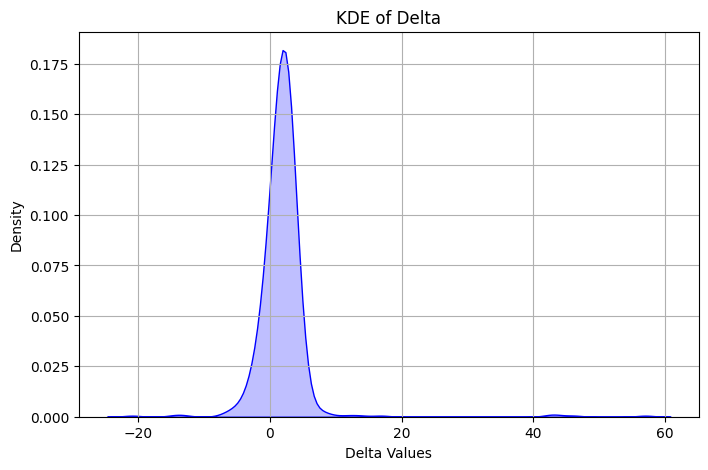

(np.float64(1.9039249146757675), 4.5672974983077514)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Compute mean and standard deviation
delta_mean = np.mean(working_data['delta'])
delta_std = np.std(working_data['delta'])

# Generate KDE plot
plt.figure(figsize=(8, 5))
sns.kdeplot(working_data['delta'], color='blue', fill=True)

plt.xlabel('Delta Values')
plt.ylabel('Density')
plt.title('KDE of Delta')
plt.grid(True)

# Show plot
plt.show()

# Return computed statistics
delta_mean, delta_std

Asian: Mean = 8.88, Std Dev = 15.55
Black or African American: Mean = 2.07, Std Dev = 4.63
White: Mean = 1.37, Std Dev = 2.91
Native Hawaiian or Other Pacific Islander: Mean = 2.79, Std Dev = 1.28


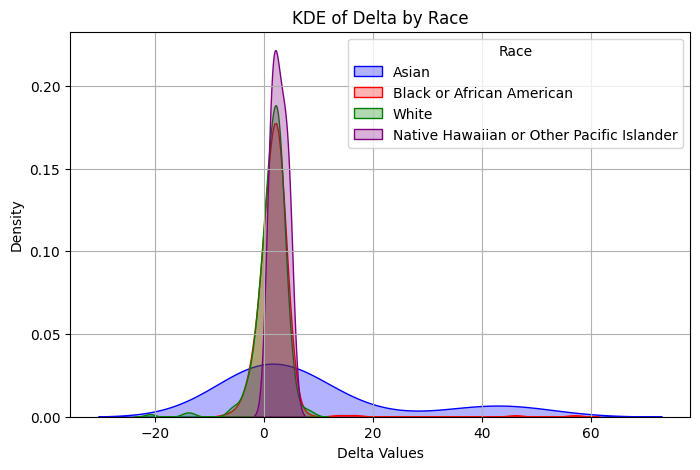

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define selected racial groups
selected_races = ['Asian', 'Black or African American', 'White', 'Native Hawaiian or Other Pacific Islander']

# Filter data for selected racial groups
filtered_data = working_data[working_data['race'].isin(selected_races)]

# Set up the plot
plt.figure(figsize=(8, 5))

# Define colors for each group
colors = {
    'Asian': 'blue',
    'Black or African American': 'red',
    'White': 'green',
    'Native Hawaiian or Other Pacific Islander': 'purple'
}

# Compute mean and standard deviation for each group
stats = {}
for race in selected_races:
    race_data = filtered_data[filtered_data['race'] == race]['delta']
    mean_val = np.mean(race_data)
    std_val = np.std(race_data)
    stats[race] = {'mean': mean_val, 'std': std_val}

    # Plot KDE
    sns.kdeplot(race_data, label=race, color=colors[race], fill=True, alpha=0.3)

# Display computed statistics
for race, values in stats.items():
    print(f"{race}: Mean = {values['mean']:.2f}, Std Dev = {values['std']:.2f}")

plt.xlabel('Delta Values')
plt.ylabel('Density')
plt.title('KDE of Delta by Race')
plt.legend(title="Race")
plt.grid(True)

# Show plot
plt.show()


In [ ]:
from scipy.stats import ttest_ind


white_data = filtered_data[filtered_data['race'] == 'White']['delta']
black_data = filtered_data[filtered_data['race'] == 'Black or African American']['delta']

# Perform independent t-test
t_stat, t_p_value = ttest_ind(white_data, black_data, equal_var=False)  # Welch's t-test

# Print results
print(f"T-Test: Statistic = {t_stat:.4f}, P-Value = {t_p_value:.4f}")

T-Test: Statistic = -2.1680, P-Value = 0.0306


In [ ]:
from scipy.stats import ttest_ind

# Extract delta values for White and Asian groups
white_data = filtered_data[filtered_data['race'] == 'White']['delta']
asian_data = filtered_data[filtered_data['race'] == 'Asian']['delta']

# Perform independent t-test
t_stat, t_p_value = ttest_ind(white_data, asian_data, equal_var=False)  # Welch's t-test

# Print results
print(f"T-Test: Statistic = {t_stat:.4f}, P-Value = {t_p_value:.4f}")

T-Test: Statistic = -1.6008, P-Value = 0.1377


<ipython-input-198-ae8cc0a4c179>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='ADMINISTERED-VISUAL-SCALES_CARD.MONKSKINTONESCALE',


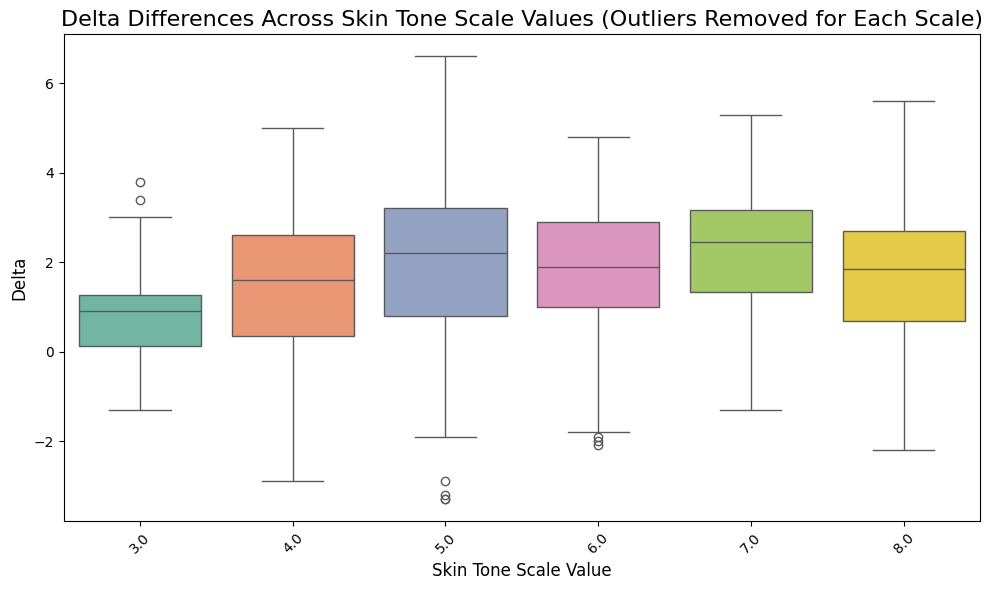

In [ ]:
import pandas as pd

# Assuming 'working_data' is already loaded
# Create an empty DataFrame to store the filtered data
filtered_data = pd.DataFrame()

# Loop through each unique skin tone scale and calculate the IQR for each
for skin_tone in working_data['ADMINISTERED-VISUAL-SCALES_CARD.MONKSKINTONESCALE'].unique():
    # Get the subset of data for the current skin tone scale
    subset = working_data[working_data['ADMINISTERED-VISUAL-SCALES_CARD.MONKSKINTONESCALE'] == skin_tone]

    # Calculate Q1, Q3, and IQR for delta values
    Q1 = subset['delta'].quantile(0.25)
    Q3 = subset['delta'].quantile(0.75)
    IQR = Q3 - Q1

    # Calculate lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out the outliers for the current skin tone scale
    filtered_subset = subset[(subset['delta'] >= lower_bound) & (subset['delta'] <= upper_bound)]

    # Append the filtered data to the final DataFrame
    filtered_data = pd.concat([filtered_data, filtered_subset])

# Now we have a filtered dataset without outliers for each skin tone scale
# Let's plot the boxplot for the filtered data
import matplotlib.pyplot as plt
import seaborn as sns

# Create the plot for the filtered data
plt.figure(figsize=(10, 6))
sns.boxplot(x='ADMINISTERED-VISUAL-SCALES_CARD.MONKSKINTONESCALE',
            y='delta',
            data=filtered_data,
            palette="Set2")

# Add titles and labels
plt.title('Delta Differences Across Skin Tone Scale Values (Outliers Removed for Each Scale)', fontsize=16)
plt.xlabel('Skin Tone Scale Value', fontsize=12)
plt.ylabel('Delta', fontsize=12)

# Rotate x-axis labels if necessary
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


<ipython-input-199-be9a76c72867>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='skin_tone_group',


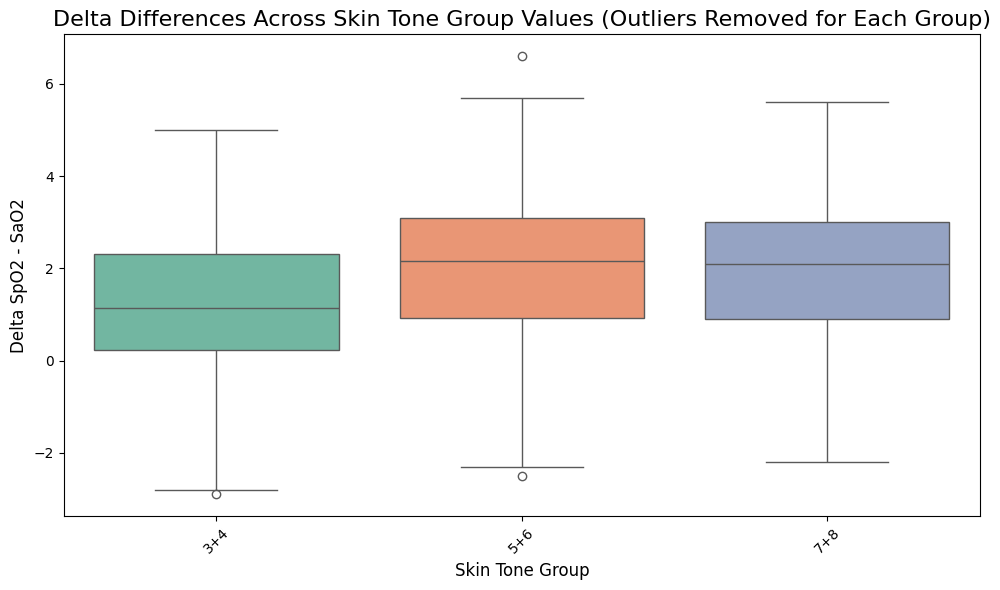

In [ ]:
import pandas as pd

# Assuming 'working_data' is already loaded
# Create an empty DataFrame to store the filtered data
filtered_data = pd.DataFrame()

# Group the skin tone scales 3+4, 5+6, 7+8
working_data['skin_tone_group'] = working_data['ADMINISTERED-VISUAL-SCALES_CARD.MONKSKINTONESCALE'].replace({3: '3+4', 4: '3+4', 5: '5+6', 6: '5+6', 7: '7+8', 8: '7+8'})

# Loop through each unique skin tone group and calculate the IQR for each
for skin_tone_group in working_data['skin_tone_group'].unique():
    # Get the subset of data for the current skin tone group
    subset = working_data[working_data['skin_tone_group'] == skin_tone_group]

    # Calculate Q1, Q3, and IQR for delta values
    Q1 = subset['delta'].quantile(0.25)
    Q3 = subset['delta'].quantile(0.75)
    IQR = Q3 - Q1

    # Calculate lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out the outliers for the current skin tone group
    filtered_subset = subset[(subset['delta'] >= lower_bound) & (subset['delta'] <= upper_bound)]

    # Append the filtered data to the final DataFrame
    filtered_data = pd.concat([filtered_data, filtered_subset])

# Now we have a filtered dataset without outliers for each skin tone group
# Let's plot the boxplot for the filtered data
import matplotlib.pyplot as plt
import seaborn as sns

# Create the plot for the filtered data
plt.figure(figsize=(10, 6))
sns.boxplot(x='skin_tone_group',
            y='delta',
            data=filtered_data,
            palette="Set2")

# Add titles and labels
plt.title('Delta Differences Across Skin Tone Group Values (Outliers Removed for Each Group)', fontsize=16)
plt.xlabel('Skin Tone Group', fontsize=12)
plt.ylabel('Delta SpO2 - SaO2', fontsize=12)

# Rotate x-axis labels if necessary
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
import scipy.stats as stats

# Group the filtered data by skin tone group
grouped_data = filtered_data.groupby('skin_tone_group')['delta']

# List of all skin tone groups
skin_tone_groups = filtered_data['skin_tone_group'].unique()

# Perform pairwise t-tests and store results
results = {}
for i in range(len(skin_tone_groups)):
    for j in range(i + 1, len(skin_tone_groups)):
        group1 = skin_tone_groups[i]
        group2 = skin_tone_groups[j]

        # Get the data for the two groups
        data1 = grouped_data.get_group(group1)
        data2 = grouped_data.get_group(group2)

        # Perform the t-test
        t_stat, p_value = stats.ttest_ind(data1, data2, equal_var=False)  # Welch's t-test (unequal variances)

        # Store the result
        results[f'{group1} vs {group2}'] = {'t-statistic': t_stat, 'p-value': p_value}

# Print the results
for comparison, result in results.items():
    print(f"{comparison}: t-statistic = {result['t-statistic']:.4f}, p-value = {result['p-value']:.4f}")


3+4 vs 5+6: t-statistic = -3.6862, p-value = 0.0003
3+4 vs 7+8: t-statistic = -3.7336, p-value = 0.0003
5+6 vs 7+8: t-statistic = 0.1263, p-value = 0.8995


In [ ]:
# Count the number of rows in each level of the skin tone scale
skin_tone_counts = working_data['ADMINISTERED-VISUAL-SCALES_CARD.MONKSKINTONESCALE'].value_counts()

# Print the counts
print(skin_tone_counts)


ADMINISTERED-VISUAL-SCALES_CARD.MONKSKINTONESCALE
5.0    161
8.0    151
7.0     94
6.0     81
4.0     60
3.0     39
Name: count, dtype: int64


In [ ]:
import numpy as np

# Assuming 'spo2' and 'sao2' columns are in the filtered_data
# Calculate the difference between spo2 and sao2
filtered_data['spo2_sao2_diff'] = filtered_data['spo2'] - filtered_data['sao2']

# Group the data by skin tone group
grouped_data = filtered_data.groupby('skin_tone_group')

# Calculate Mean Squared Error for each group
mse_results = {}
for group, data in grouped_data:
    # Calculate the MSE for each group
    mse = np.mean((data['spo2_sao2_diff'])**2)
    mse_results[group] = mse

# Print the MSE results for each group
for group, mse in mse_results.items():
    print(f'MSE for group {group}: {mse:.4f}')


MSE for group 3+4: 4.0729
MSE for group 5+6: 6.6109
MSE for group 7+8: 5.8325


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming 'working_data' contains the features and target
X = working_data.drop(columns=['sao2'])  # Features (drop target column)
y = working_data['sao2']  # Target (sao2)

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now you have X_train, X_test, y_train, y_test for training and evaluation


In [ ]:
full_test_set = pd.concat([X_test, y_test], axis=1)

In [ ]:
import numpy as np
from sklearn.metrics import r2_score

# Assuming 'spo2' and 'sao2' columns are in the full_test_set
# Group the data by skin tone group
grouped_data = full_test_set.groupby('skin_tone_group')

# Initialize dictionaries to store MSE and R² results
mse_results = {}
r2_results = {}

# Calculate MSE and R² for each group
for group, data in grouped_data:
    # Calculate the MSE for each group between 'spo2' and 'sao2'
    mse = np.mean((data['spo2'] - data['sao2'])**2)
    mse_results[group] = mse

    # Calculate the R² for each group between 'spo2' and 'sao2'
    r2 = r2_score(data['sao2'], data['spo2'])
    r2_results[group] = r2

# Print the MSE and R² results for each group
for group in mse_results:
    print(f'MSE for group {group}: {mse_results[group]:.4f}')
    print(f'R² for group {group}: {r2_results[group]:.4f}')


MSE for group 3+4: 3.2248
R² for group 3+4: 0.1681
MSE for group 5+6: 6.5650
R² for group 5+6: -0.1678
MSE for group 7+8: 10.7151
R² for group 7+8: -0.7047


In [ ]:
X_decision_tree = {'spo2', 'gender', 'age', 'Heart rate', 'Body temperature', 'Body weight', 'Body height', 'skin_tone_group', 'Blood pressure device Cuff pressure.mean', 'Respiratory rate'}

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

# Assuming full_test_set is your dataset

# Select the features for the decision tree model
X_decision_tree = ['spo2', 'gender', 'age', 'Heart rate', 'Body temperature',
                   'Body weight', 'Body height', 'skin_tone_group',
                   'Blood pressure device Cuff pressure.mean', 'Respiratory rate']

# Define X (features) and y (target)
x_decision_train = X_train[X_decision_tree]
x_decision_test = X_test[X_decision_tree]

# Handle categorical (qualitative) data
# Label Encoding for 'skin_tone_group' (ordinal)
label_encoder = LabelEncoder()
x_decision_train['skin_tone_group'] = label_encoder.fit_transform(x_decision_train['skin_tone_group'])

# One-Hot Encoding for 'gender' (nominal)
x_decision_train = pd.get_dummies(x_decision_train, columns=['gender'], drop_first=True)


x_decision_test['skin_tone_group'] = label_encoder.fit_transform(x_decision_test['skin_tone_group'])

# One-Hot Encoding for 'gender' (nominal)
x_decision_test = pd.get_dummies(x_decision_test, columns=['gender'], drop_first=True)

<ipython-input-207-42476b5f7f82>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_decision_train['skin_tone_group'] = label_encoder.fit_transform(x_decision_train['skin_tone_group'])
<ipython-input-207-42476b5f7f82>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_decision_test['skin_tone_group'] = label_encoder.fit_transform(x_decision_test['skin_tone_group'])


In [ ]:
x_decision_test

,spo2,age,Heart rate,Body temperature,Body weight,Body height,skin_tone_group,Blood pressure device Cuff pressure.mean,Respiratory rate,gender_MALE
521,99.0,80.0,112.0,37.0,NaN,76.535,2,NaN,29.0,True
285,100.0,68.0,88.0,37.7,NaN,64.016,1,NaN,20.0,False
513,96.0,57.0,71.0,37.4,NaN,65.000,0,77.0,18.0,False
332,98.0,38.0,106.0,37.0,NaN,NaN,2,63.0,20.0,False
211,100.0,21.0,141.0,38.2,NaN,64.488,0,NaN,29.0,False
...,...,...,...,...,...,...,...,...,...,...
549,100.0,68.0,121.0,38.3,NaN,72.008,1,81.0,23.0,True
109,98.0,74.0,76.0,37.0,NaN,67.992,2,70.0,14.0,True
362,92.0,55.0,104.0,37.6,NaN,72.992,2,NaN,18.0,True
421,98.0,60.0,69.0,36.7,NaN,72.008,2,NaN,24.0,True


In [ ]:
from sklearn.impute import KNNImputer

knn_imputer = KNNImputer(n_neighbors=5)
x_decision_train_imputed = knn_imputer.fit_transform(x_decision_train)
x_decision_test_imputed = knn_imputer.fit_transform(x_decision_test)

In [ ]:
X_train_imputed_df = pd.DataFrame(x_decision_train_imputed, columns=x_decision_train.columns)
X_test_imputed_df = pd.DataFrame(x_decision_test_imputed, columns=x_decision_test.columns)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the Decision Tree Regressor model
model = DecisionTreeRegressor(random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error']
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train_imputed_df, y_train)

# Get the best model after hyperparameter tuning
best_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test_imputed_df)

# Evaluate the best model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Mean Squared Error: {mse:.4f}')
print(f'R-squared: {r2:.4f}')

Best Parameters: {'criterion': 'absolute_error', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5}
Mean Squared Error: 4.5789
R-squared: 0.1979


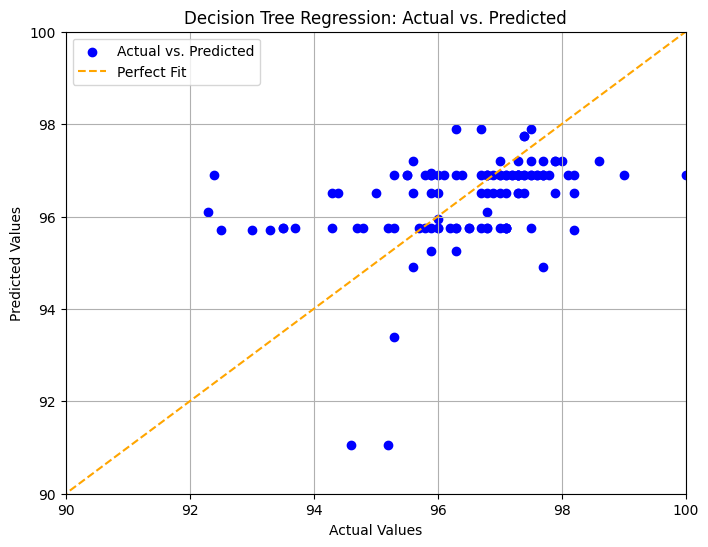

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Scatter plot of actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Actual vs. Predicted')

# Perfect fit line (y = x) for reference
x_vals = np.linspace(min(y_test), max(y_test), 100)
plt.plot(x_vals, x_vals, color='orange', linestyle='dashed', label='Perfect Fit')

# Labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.xlim(90, 100)
plt.ylim(90, 100)
plt.title("Decision Tree Regression: Actual vs. Predicted")
plt.legend()
plt.grid()

# Show plot
plt.show()


In [ ]:
x_decision_train

,spo2,age,Heart rate,Body temperature,Body weight,Body height,skin_tone_group,Blood pressure device Cuff pressure.mean,Respiratory rate,gender_MALE
131,98.0,63.0,85.0,37.000000,NaN,65.984,0,96.0,12.0,False
153,97.0,63.0,78.0,36.600000,NaN,NaN,0,NaN,16.0,False
77,99.0,70.0,65.0,36.600000,3259.28,70.079,1,NaN,22.0,True
439,100.0,27.0,109.0,37.400000,3756.64,NaN,2,NaN,30.0,False
256,98.0,70.0,92.0,36.800000,NaN,70.984,2,NaN,20.0,True
...,...,...,...,...,...,...,...,...,...,...
71,100.0,57.0,91.0,37.000000,NaN,68.504,1,87.0,18.0,True
106,100.0,47.0,90.0,37.000000,NaN,62.992,1,62.0,18.0,False
271,96.0,68.0,71.0,36.777778,NaN,NaN,1,72.0,24.0,False
437,100.0,27.0,97.0,37.500000,NaN,NaN,2,NaN,24.0,False


In [ ]:
import pickle

# Save the best model as a .pkl file
with open('/content/decisiontree1.pkl', 'wb') as file:
    pickle.dump(best_model, file)

from google.colab import files

# Download the file
files.download('/content/decisiontree1.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
len(y_pred)

118

In [ ]:
y_test

,sao2
521,95.8
285,97.1
513,97.3
332,95.2
211,97.5
...,...
549,96.1
109,95.9
362,92.3
421,97.3


In [ ]:
y_test

,sao2
521,95.8
285,97.1
513,97.3
332,95.2
211,97.5
...,...
549,96.1
109,95.9
362,92.3
421,97.3


In [ ]:
len(y_pred)

118

In [ ]:
print(f"Length of y_test: {len(y_test)}")
print(f"Length of y_pred: {len(y_pred)}")
print(f"Shape of X_test_imputed_df: {X_test_imputed_df.shape}")

Length of y_test: 118
Length of y_pred: 118
Shape of X_test_imputed_df: (118, 10)


In [ ]:
y_test

,sao2
521,95.8
285,97.1
513,97.3
332,95.2
211,97.5
...,...
549,96.1
109,95.9
362,92.3
421,97.3


In [ ]:
full_test_set

,spo2,age,Heart rate,Body temperature,Body weight,Body height,skin_tone_group,Blood pressure device Cuff pressure.mean,Respiratory rate,gender_MALE,sao2,pred
0,99.0,80.0,112.0,37.0,2951.694,76.5350,2.0,84.8,29.0,1.0,95.8,97.6
1,100.0,68.0,88.0,37.7,3540.060,64.0160,1.0,72.2,20.0,0.0,97.1,97.6
2,96.0,57.0,71.0,37.4,3395.136,65.0000,0.0,77.0,18.0,0.0,97.3,96.7
3,98.0,38.0,106.0,37.0,4198.264,67.8032,2.0,63.0,20.0,0.0,95.2,95.8
4,100.0,21.0,141.0,38.2,3639.530,64.4880,0.0,74.2,29.0,0.0,97.5,98.3
...,...,...,...,...,...,...,...,...,...,...,...,...
113,100.0,68.0,121.0,38.3,3052.576,72.0080,1.0,81.0,23.0,1.0,96.1,97.0
114,98.0,74.0,76.0,37.0,4163.698,67.9920,2.0,70.0,14.0,1.0,95.9,97.4
115,92.0,55.0,104.0,37.6,3729.126,72.9920,2.0,88.0,18.0,1.0,92.3,96.7
116,98.0,60.0,69.0,36.7,3944.698,72.0080,2.0,72.8,24.0,1.0,97.3,90.3


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# Assuming 'y_test' and 'y_pred' are your true and predicted values as NumPy arrays
# Also assuming you have a 'skin_tone_group' column in your data

# Create a DataFrame to combine the true values (y_test), predictions (y_pred), and the skin tone group
full_test_set = X_test_imputed_df.copy()  # Use your X_test DataFrame
y_test.reset_index(drop=True, inplace=True)
full_test_set['sao2'] = y_test

full_test_set['pred'] = y_pred


# Check if y_test and y_pred are aligned correctly in the DataFrame

# Group the data by skin tone group
grouped_data = full_test_set.groupby('skin_tone_group')

# Calculate Mean Squared Error for each group
mse_results = {}
for group, data in grouped_data:
    # Calculate the MSE for each group
    mse = mean_squared_error(data['sao2'], data['pred'])
    mse_results[group] = mse

# Print the MSE results for each group
for group, mse in mse_results.items():
    print(f'MSE for group {group}: {mse:.4f}')


MSE for group 0.0: 2.9624
MSE for group 1.0: 3.3987
MSE for group 2.0: 6.3090


In [ ]:
from sklearn.tree import DecisionTreeRegressor

# Assuming 'X' contains features (including categorical columns) and 'y' is the target ('sao2')
model = DecisionTreeRegressor()

# Train the model
model.fit(X_train, y_train)  # X_train contains both numerical and categorical data, y_train is sao2

# Predict
y_pred = model.predict(X_test)  # Predict on test set

(468, 16)

In [ ]:
filtered_data.columns

Index(['person_id', 'sao2', 'spo2', 'gender', 'race', 'ethnicity',
       'visit_occurrence_id', 'age', 'Heart rate', 'Body temperature',
       'Body weight', 'Body height',
       'ADMINISTERED-VISUAL-SCALES_CARD.MONKSKINTONESCALE',
       'Blood pressure device Cuff pressure.mean', 'Respiratory rate', 'delta',
       'skin_tone_group', 'spo2_sao2_diff'],
      dtype='object')

## Download image data

The image data are stored on Google Cloud. Android and iPhone photos are stored sepepratelty with the naming convention<person_id>_<location_id>_<device>. The location translations can be found in https://physionet.org/content/encode-skin-color/1.0.0/.



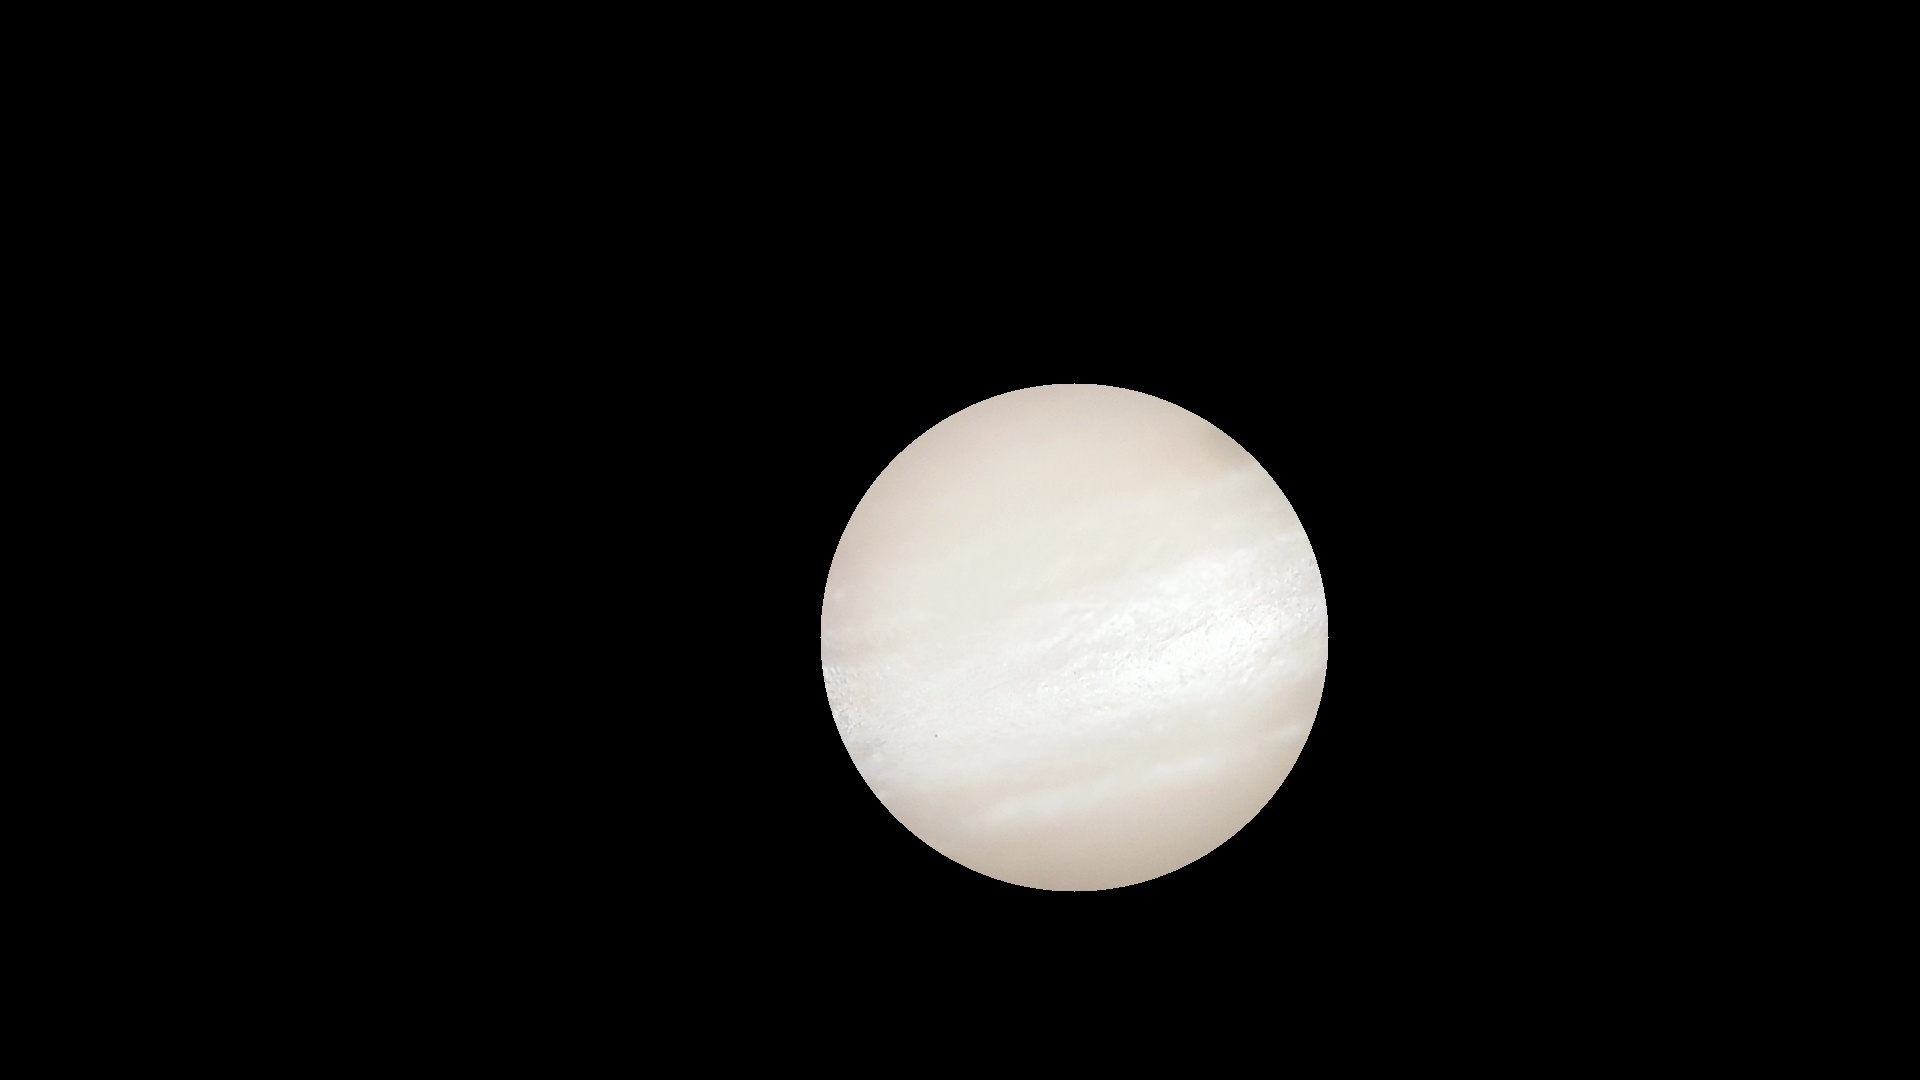

In [ ]:
#sample image

client = storage.Client()

# Specify the bucket and the image file name
bucket_name = 'aiwonglab_encode'
image_file_name = 'image_records/Android/android_no_PHI/0_10_android.jpg'

# Get the bucket and blob (file)
bucket = client.get_bucket(bucket_name)
blob = bucket.blob(image_file_name)

# Download the image file as bytes
image_bytes = blob.download_as_bytes()

# Open the image with PIL
image = Image.open(io.BytesIO(image_bytes))

# Display the image in the notebook
display(image)

In [ ]:
full_test_set['age'].mean()

np.float64(55.13559322033898)

In [ ]:
X_train_imputed_df

,spo2,age,Heart rate,Body temperature,Body weight,Body height,skin_tone_group,Blood pressure device Cuff pressure.mean,Respiratory rate,gender_MALE
0,98.0,63.0,85.0,37.000000,3358.752,65.9840,0.0,96.0,12.0,0.0
1,97.0,63.0,78.0,36.600000,3607.080,65.9920,0.0,96.6,16.0,0.0
2,99.0,70.0,65.0,36.600000,3259.280,70.0790,1.0,78.6,22.0,1.0
3,100.0,27.0,109.0,37.400000,3756.640,70.8896,2.0,83.4,30.0,0.0
4,98.0,70.0,92.0,36.800000,3896.322,70.9840,2.0,79.4,20.0,1.0
...,...,...,...,...,...,...,...,...,...,...
463,100.0,57.0,91.0,37.000000,3472.332,68.5040,1.0,87.0,18.0,1.0
464,100.0,47.0,90.0,37.000000,3531.594,62.9920,1.0,62.0,18.0,0.0
465,96.0,68.0,71.0,36.777778,3473.040,69.3070,1.0,72.0,24.0,0.0
466,100.0,27.0,97.0,37.500000,4033.184,71.5040,2.0,76.4,24.0,0.0


In [ ]:
X_train_xgb = X_train_imputed_df.copy()
X_test_xgb = X_test_imputed_df.copy()

In [ ]:
y_train

,sao2
131,93.0
153,89.4
77,96.3
439,97.9
256,96.7
...,...
71,95.2
106,95.5
271,93.0
437,97.2


In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Use XGBRegressor for compatibility with GridSearchCV
from xgboost import XGBRegressor

# Create an XGBRegressor model
xgb_model = XGBRegressor(objective='reg:squarederror', eval_metric='rmse')

# Define the parameter grid for GridSearchCV
param_grid = {
    'max_depth': [3, 6, 10],              # Maximum depth of trees
    'learning_rate': [0.01, 0.1, 0.3],   # Step size shrinkage
    'n_estimators': [50, 100, 200],      # Number of boosting rounds
    'subsample': [0.8, 0.9, 1.0],        # Fraction of training data used per tree
    'colsample_bytree': [0.8, 0.9, 1.0]  # Fraction of features used per tree
}

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=3, verbose=1)

# Fit the GridSearchCV
grid_search.fit(X_train_xgb, y_train)

# Get the best parameters from GridSearchCV
print(f"Best parameters: {grid_search.best_params_}")

# Use the best model to make predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_xgb)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

# Calculate R² (coefficient of determination)
r2 = r2_score(y_test, y_pred)
print(f'R²: {r2}')


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 50, 'subsample': 0.8}
RMSE: 2.1236375793346234
R²: 0.21001931358413384


In [ ]:
y_pred

array([95.95521 , 95.82005 , 95.7988  , 95.40133 , 95.81492 , 95.943504,
       95.399605, 95.5187  , 95.82457 , 95.70375 , 95.32545 , 92.91585 ,
       95.80606 , 95.02754 , 95.38547 , 93.62641 , 95.46586 , 95.71031 ,
       95.16718 , 95.37366 , 95.695244, 95.61076 , 94.496925, 95.594215,
       96.032326, 95.61289 , 95.672615, 95.81598 , 95.80053 , 93.849915,
       95.450485, 95.65784 , 96.05952 , 95.77466 , 95.86791 , 95.59847 ,
       95.41337 , 96.05767 , 95.11884 , 95.58365 , 95.81293 , 95.74535 ,
       96.10352 , 95.88459 , 95.92024 , 95.83252 , 96.04136 , 95.67836 ,
       95.63962 , 95.70992 , 95.55897 , 95.57439 , 95.771416, 95.32624 ,
       95.77054 , 95.865906, 95.34352 , 95.919975, 95.36991 , 95.4496  ,
       95.2264  , 93.19035 , 96.115295, 95.79389 , 95.5538  , 96.03518 ,
       95.94112 , 95.93426 , 95.73366 , 95.787964, 95.84915 , 96.03539 ,
       95.28632 , 95.367355, 92.25671 , 93.6702  , 95.85354 , 95.618195,
       95.9072  , 95.44638 , 95.70719 , 95.957596, 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# Assuming 'y_test' and 'y_pred' are your true and predicted values as NumPy arrays
# Also assuming you have a 'skin_tone_group' column in your data

# Create a DataFrame to combine the true values (y_test), predictions (y_pred), and the skin tone group
full_test_set = X_test_imputed_df.copy()  # Use your X_test DataFrame
y_test.reset_index(drop=True, inplace=True)
full_test_set['sao2'] = y_test

full_test_set['pred'] = y_pred


# Check if y_test and y_pred are aligned correctly in the DataFrame

# Group the data by skin tone group
grouped_data = full_test_set.groupby('skin_tone_group')

# Calculate Mean Squared Error for each group
mse_results = {}
for group, data in grouped_data:
    # Calculate the MSE for each group
    mse = mean_squared_error(data['sao2'], data['pred'])
    mse_results[group] = mse

# Print the MSE results for each group
for group, mse in mse_results.items():
    print(f'MSE for group {group}: {mse:.4f}')


MSE for group 0.0: 4.3432
MSE for group 1.0: 4.1339
MSE for group 2.0: 4.9175


In [ ]:
print(X_train_imputed_df['skin_tone_group'].unique())
print(X_test_imputed_df['skin_tone_group'].unique())

[0. 1. 2.]
[2. 1. 0.]
